In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [4]:
datafile="/data1/users/bpnachman/gaia/gaiascan_l315.0_b66.4_ra197.7_dec4.0.npy"
gaiadata=np.load(datafile,allow_pickle=True)

In [14]:
gaiadata2 = np.array(gaiadata[:,[9,8,6,7,4,5]]).astype('float32')

In [16]:
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [38]:
gaiadata2 = gaiadata2[gaiadata2[:,3] < 13]

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

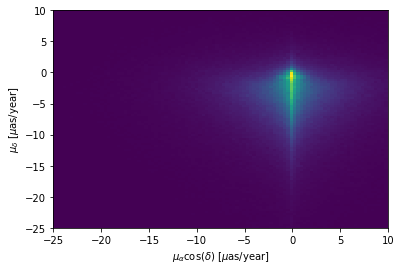

In [39]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

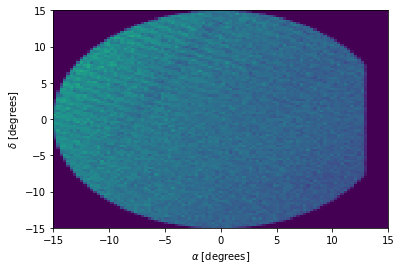

In [40]:
import matplotlib
#norm = matplotlib.colors.LogNorm()
a,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)],vmin = 0, vmax = 500)
#plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")



In [64]:
def build_data_arrays(SR, SB, gaiadata2):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec
    
    Xad = gaiadata2[:, 3]-center_ra
    Yad = gaiadata2[:, 2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5]]
    gaiadata2 = np.c_[gaiadata2[:,0],gaiadata2[:,1], Xad, Yad, gaiadata2[:,4],gaiadata2[:,5]]
    
    return SR, SB, gaiadata2

In [65]:
threshold_arr_size = 10000

In [66]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [67]:
def find_SR_SB_pointers(pointers, increment, data_arr):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

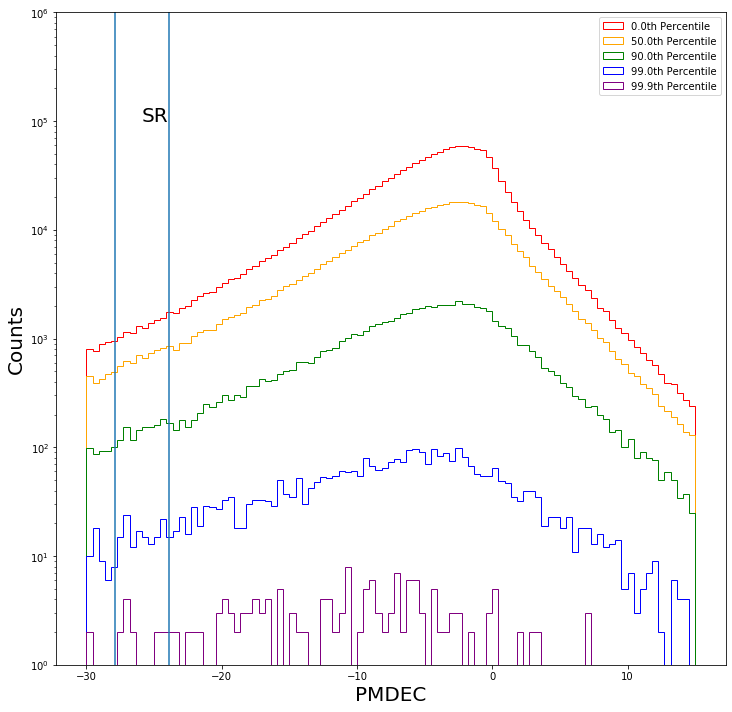

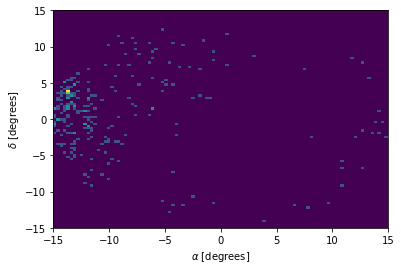

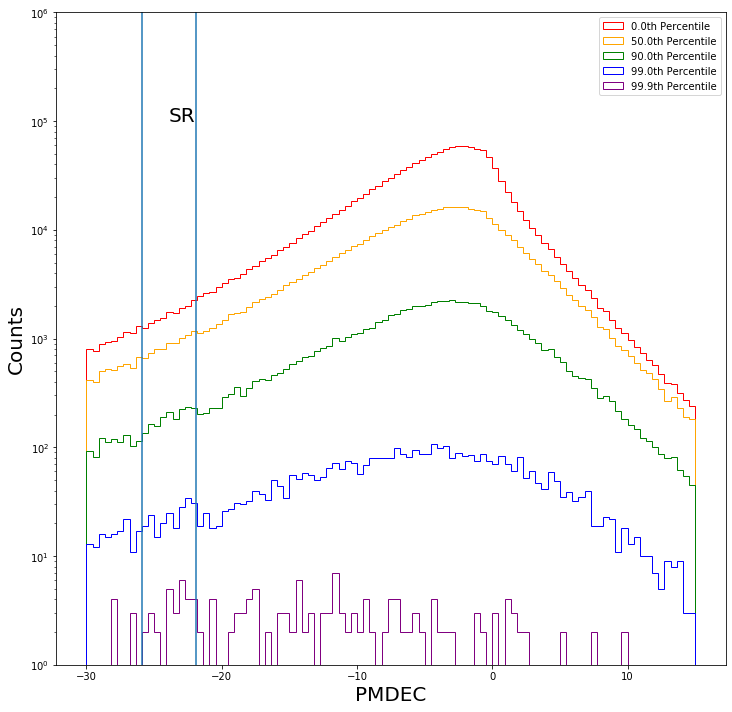

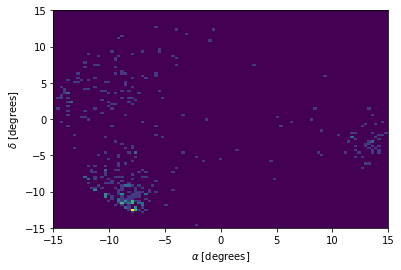

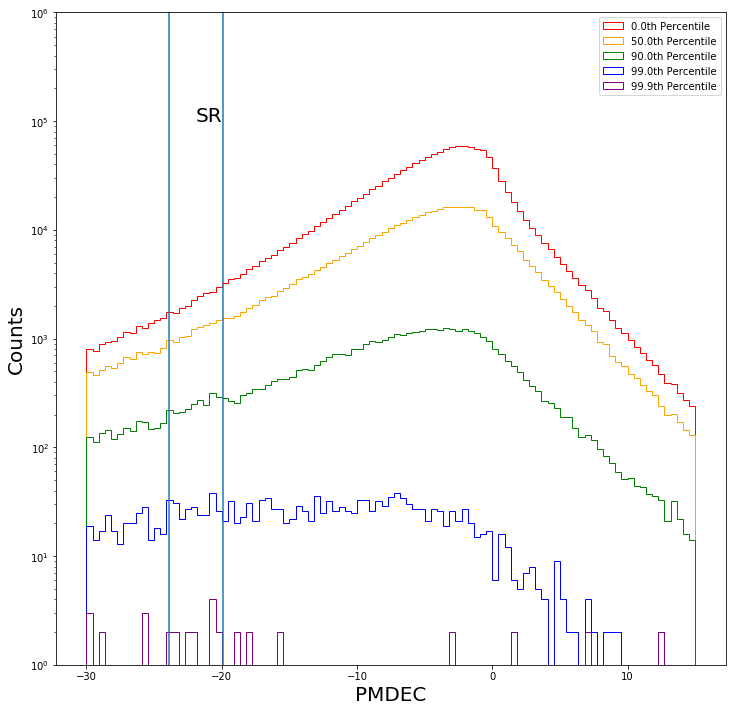

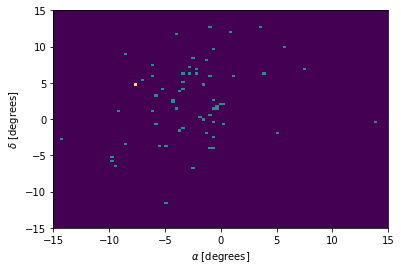

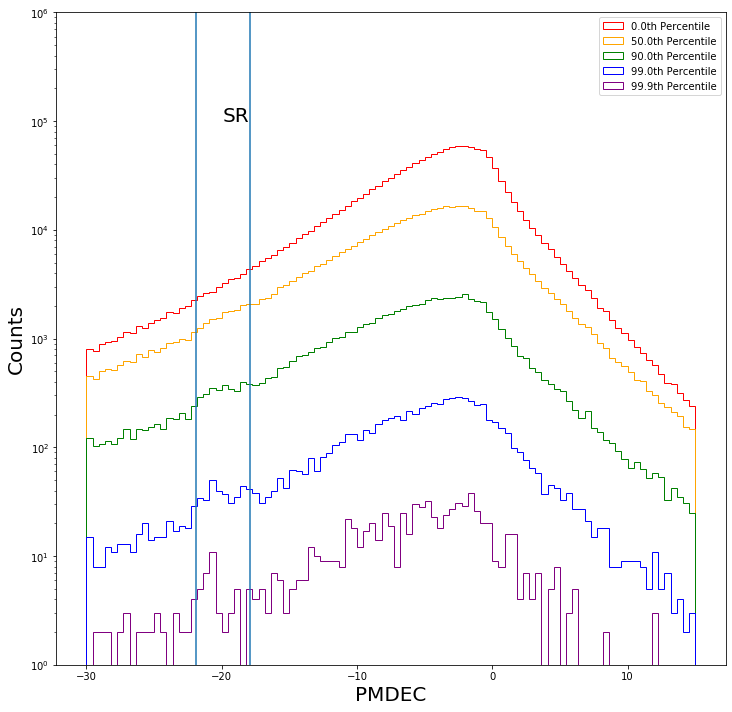

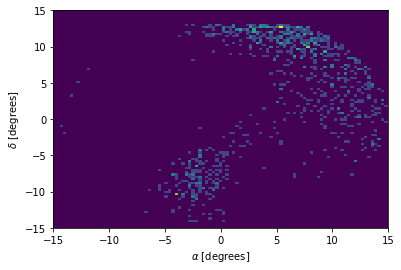

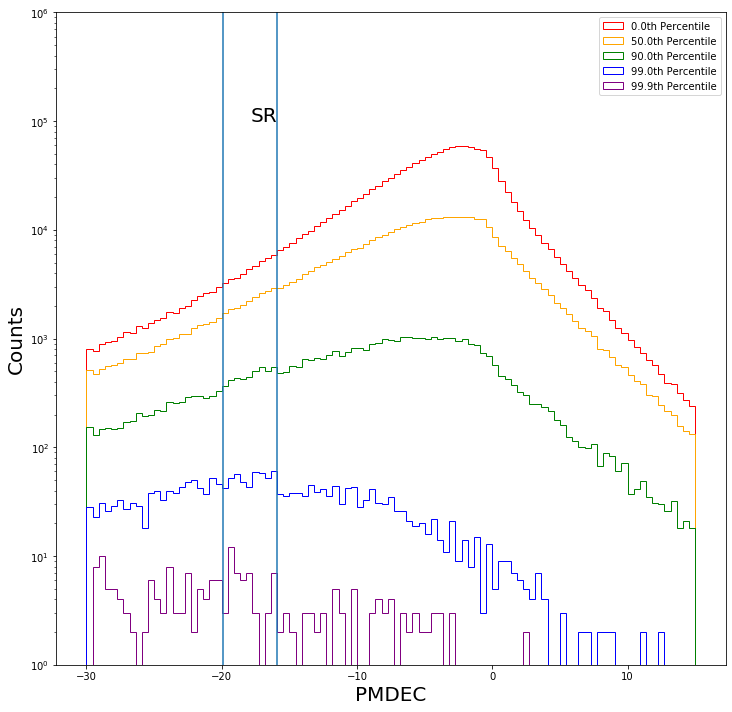

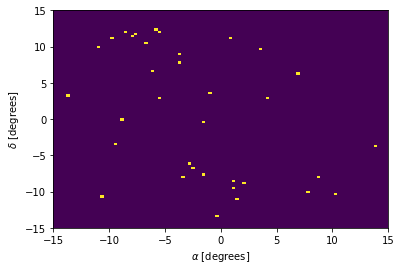

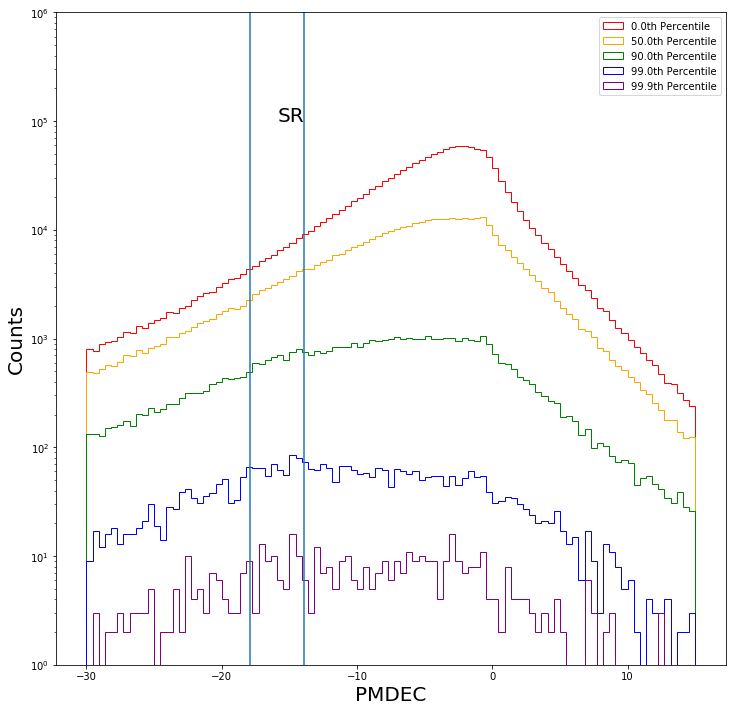

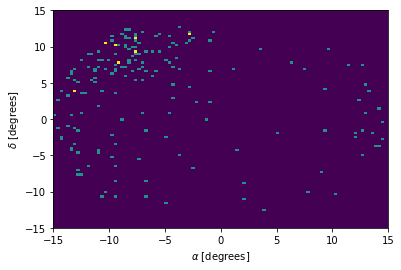

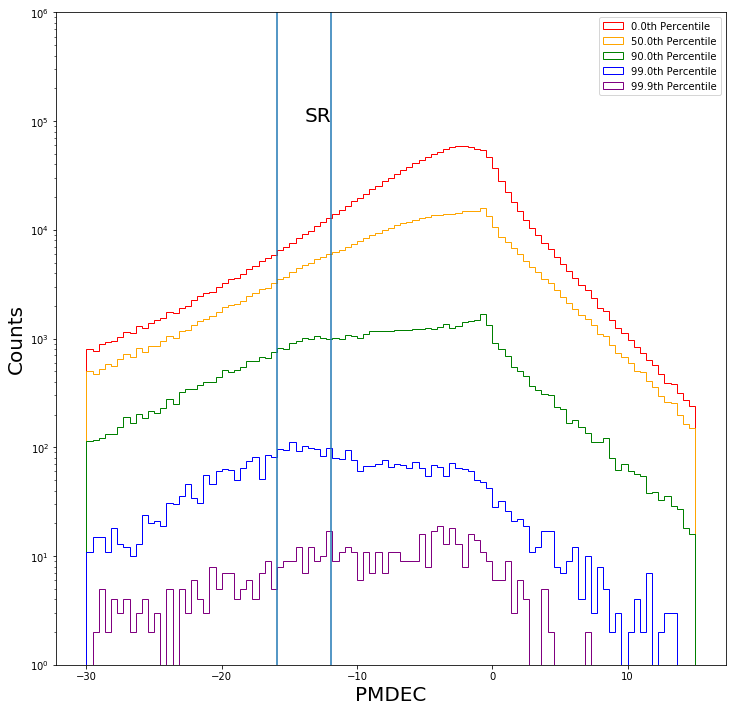

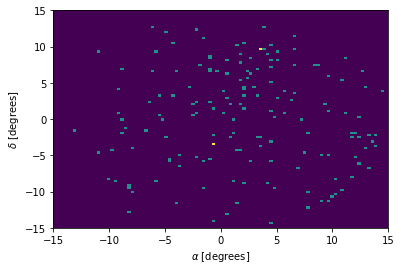

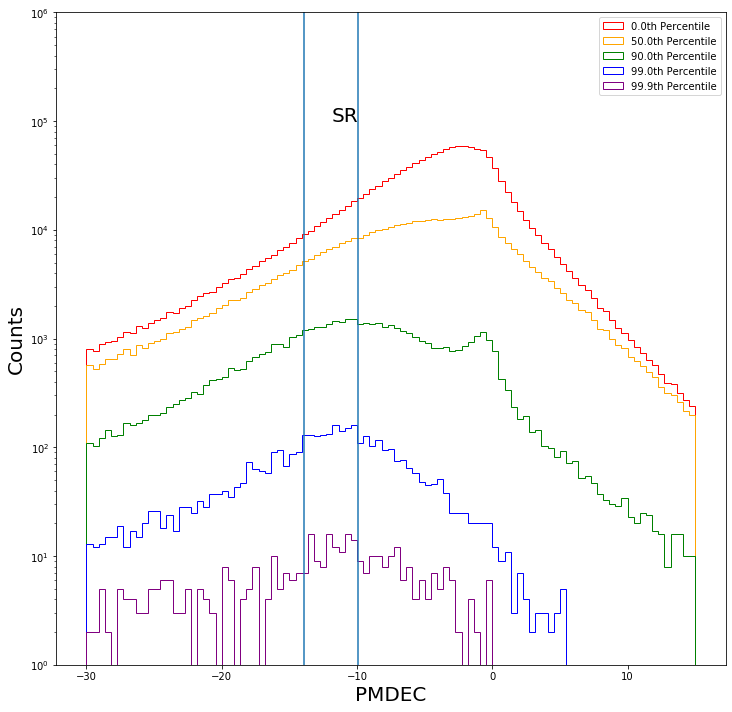

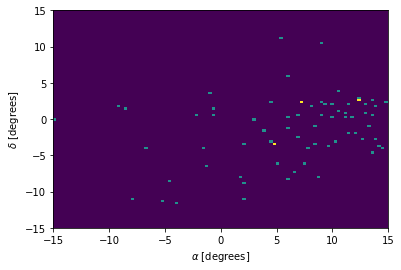

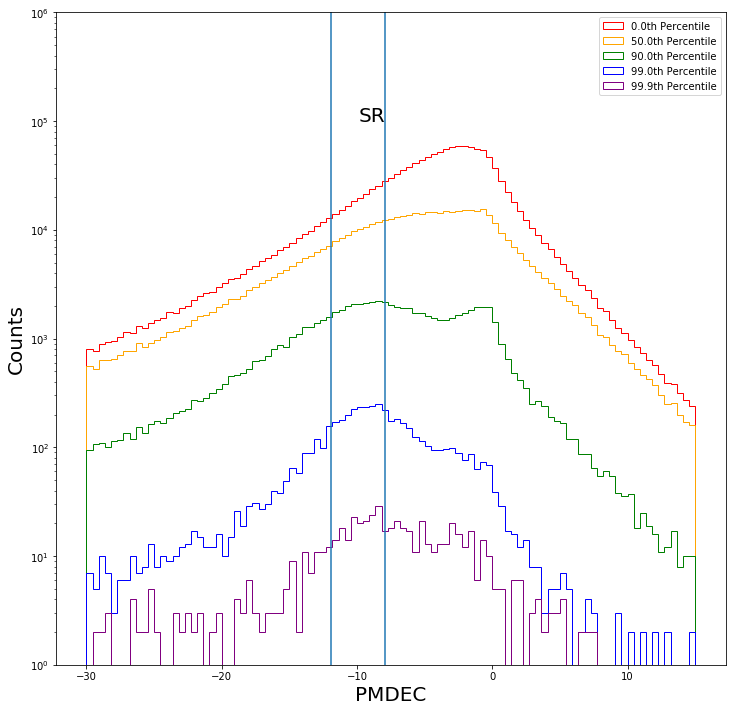

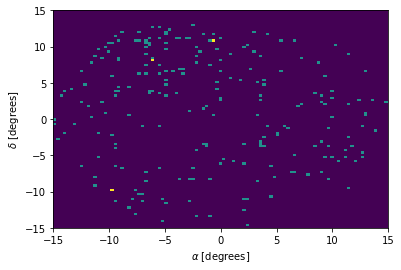

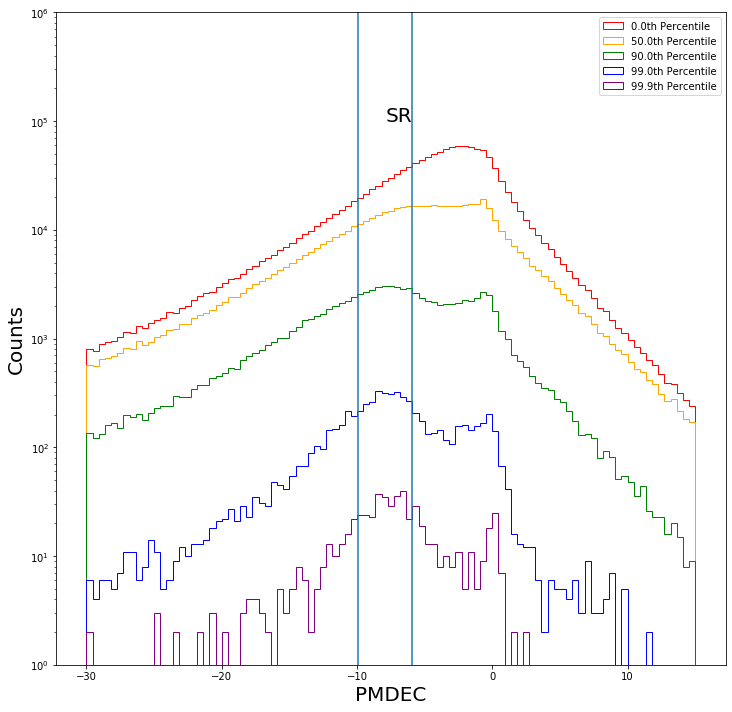

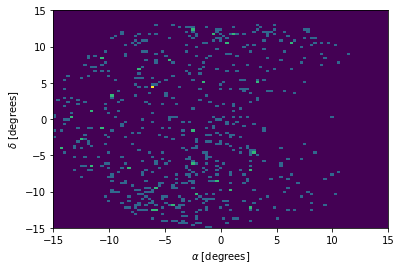

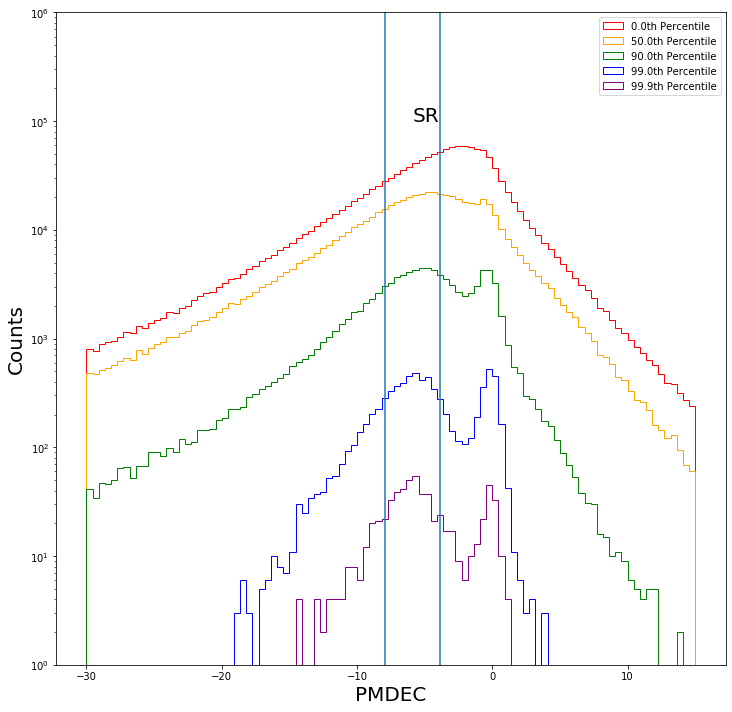

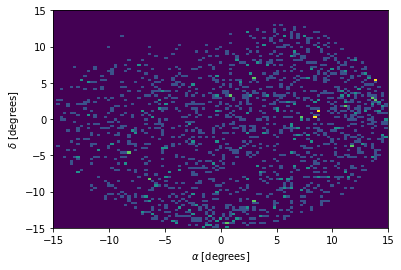

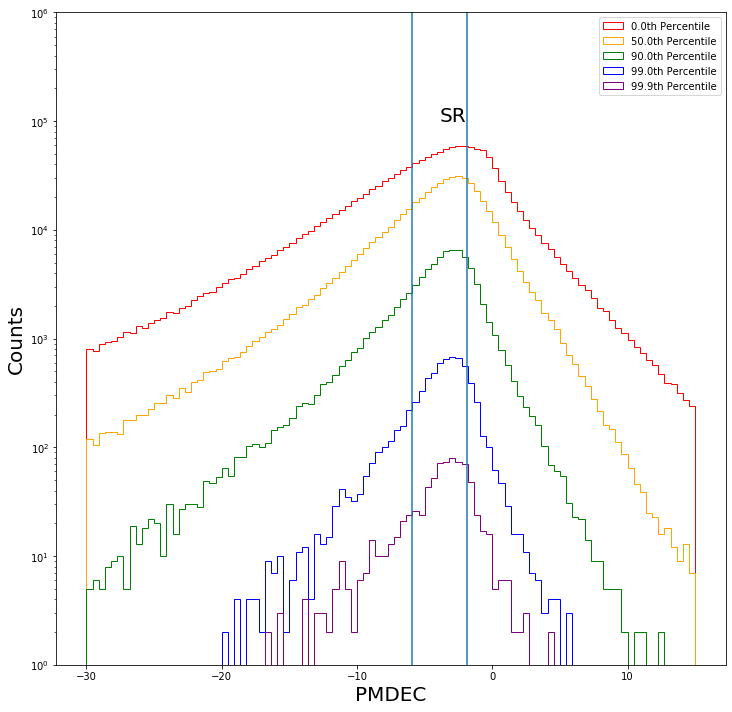

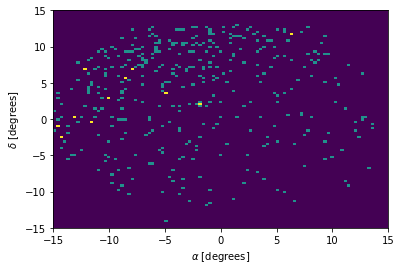

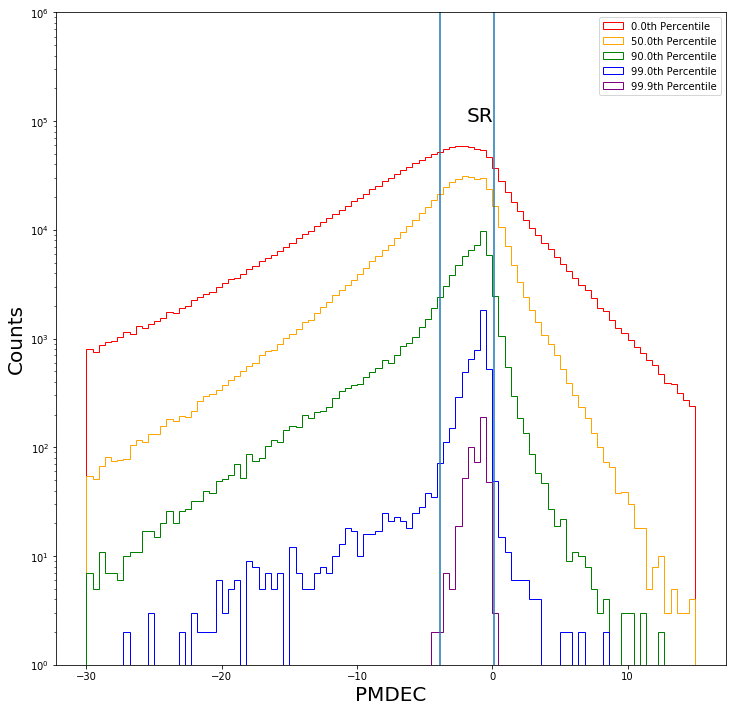

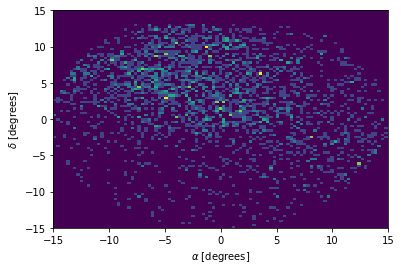

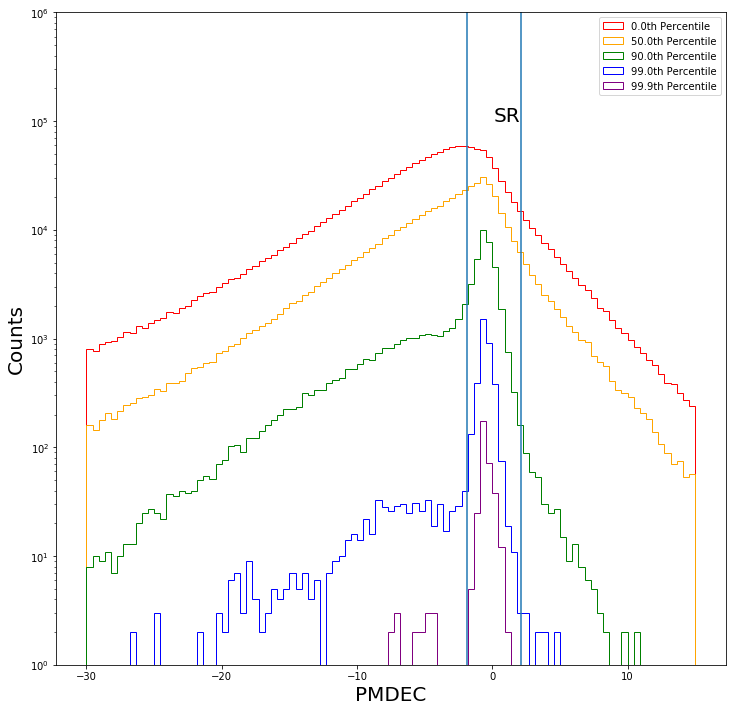

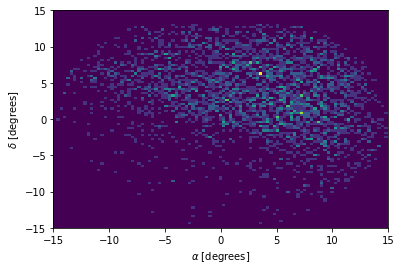

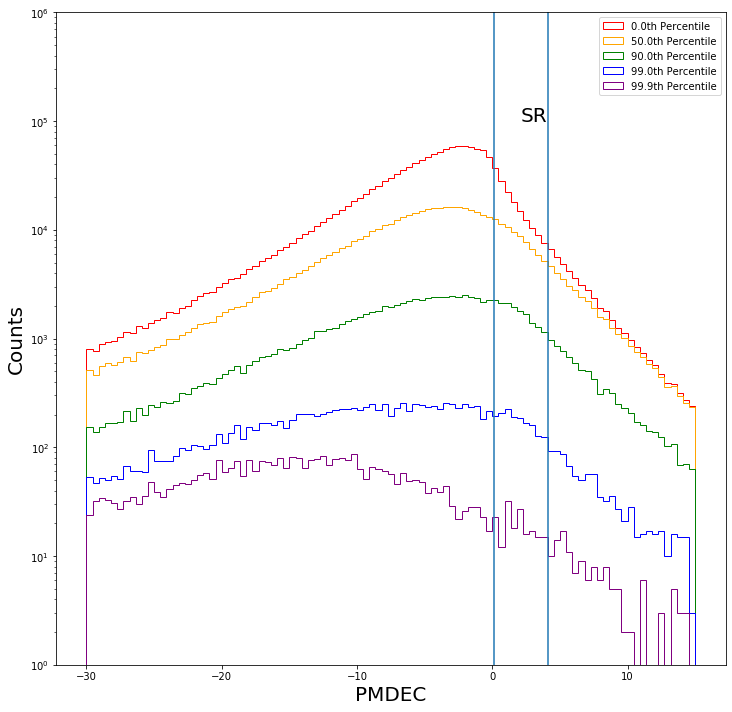

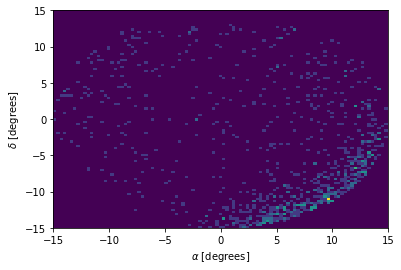

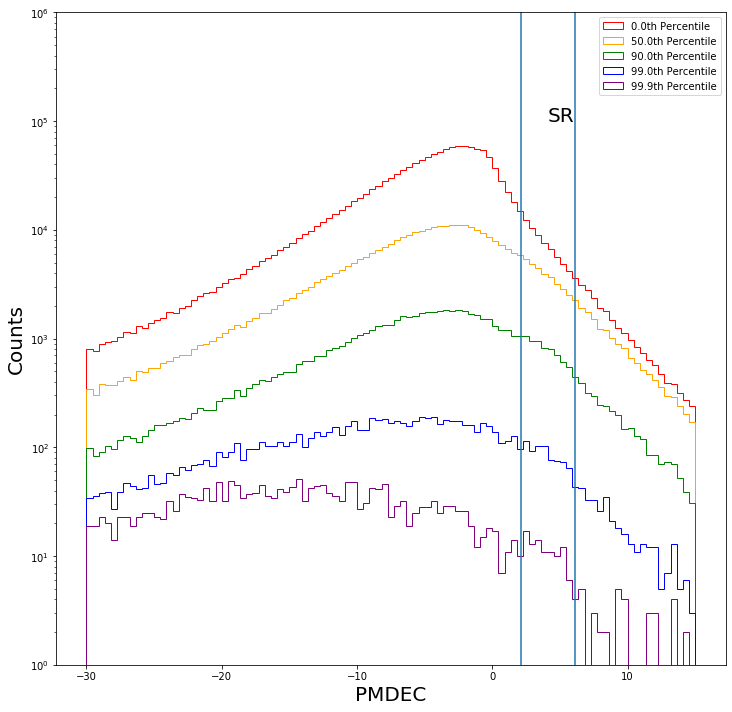

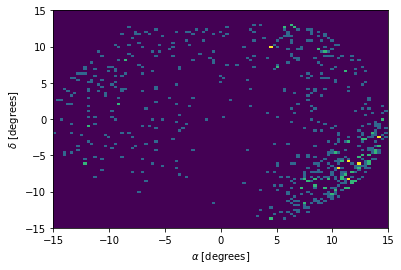

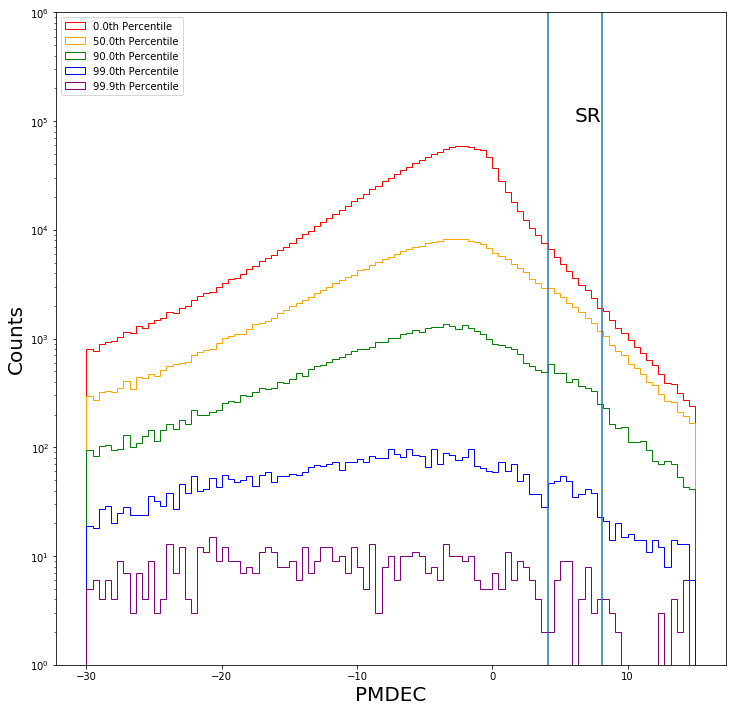

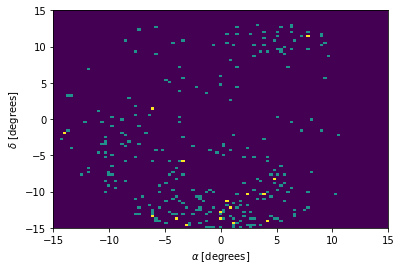

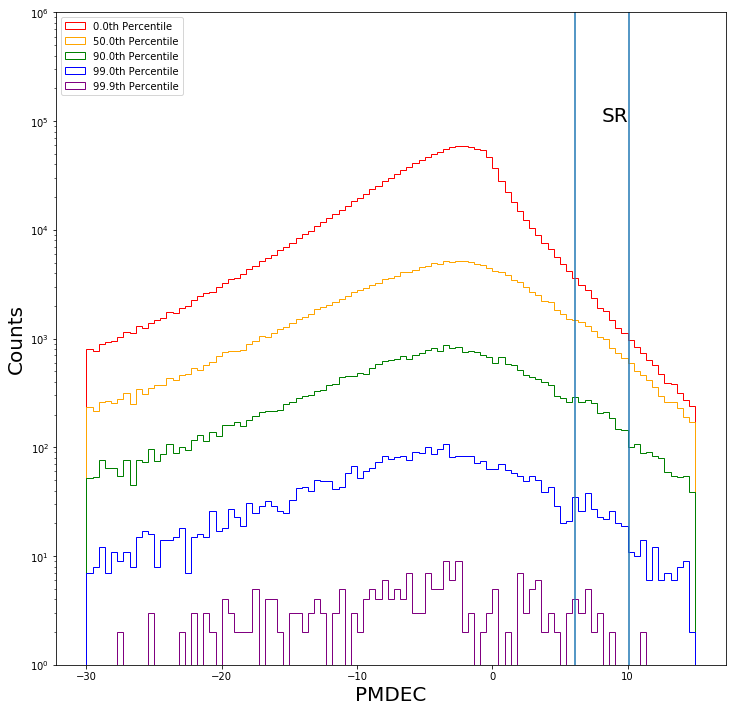

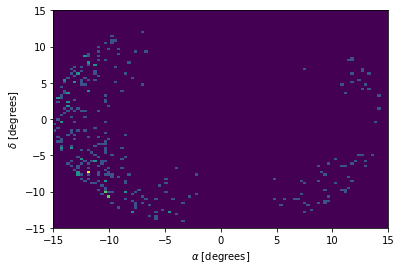

In [72]:
def build_model(SR, SB, num_models, all_data, plot_cuts = False):
    
    X = np.concatenate([SR,SB])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

    myscalar = preprocessing.StandardScaler()
    myscalar.fit(X)
    X_scaled = myscalar.transform(X)
    all_data_scaled = myscalar.transform(all_data)

    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)


    for i in range(num_models):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
        preds_all = model.predict(all_data_scaled[:, 1:]) 
        
        cuts = [0.,0.5,0.9,0.99, 0.999]
        bins_cuts = np.zeros((len(cuts), 99))
        stars_near_0 = []
        if plot_cuts:
            plt.figure(figsize = (12, 12))
            #plt.hist(stream[:,0], alpha = 0.5, bins = np.linspace(-30, 10, 100))
            plt.yscale('log')
            plt.ylim([1, 10e5])
            plt.axvline(pointers[1])
            plt.axvline(pointers[2])
            title_str = 'Cuts on pmdec'
            plt.ylabel('Counts', fontsize = 20)
            plt.xlabel('PMDEC', fontsize= 20)
            for j in range(len(cuts)):
    
                
                cut = cuts[j]
            

            
                
                X_unscaled = myscalar.inverse_transform(X_scaled[:, :6])
                all_data_unscaled = myscalar.inverse_transform(all_data_scaled[:, :6])
                X_pass_all = all_data_unscaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                if cut == 0.99:
                    stars_near_0 = X_pass_all[(X_pass_all[:,0] >-1) * (X_pass_all[:,0] <1)]
                plt.hist(X_pass_all[:,0], bins = np.linspace(-30, 15, 100), color = colors[j], alpha = 1, histtype = 'step', label = str(cut*100) + 'th Percentile')
            plt.text((pointers[1] + pointers[2])/2, 1e5, 'SR', fontsize = 20)
            plt.legend()
            plt.show()
    
        return stars_near_0

start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
colors = ['red', 'orange', 'green', 'blue', 'purple']

#where the turnaround occurs
end_point = max(gaiadata2[:,0])

while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)
    if len(SR) >= threshold_arr_size:
        SR, SB, all_data = build_data_arrays(SR, SB, gaiadata2)
        stars_near_0 = build_model(SR, SB, 1, all_data, True)
        #_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)],vmin = 0, vmax = 500)
        _,_,_,_=plt.hist2d(stars_near_0[:,3], stars_near_0[:,2],bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
        plt.xlabel(r"$\alpha$ [degrees]")
        plt.ylabel(r"$\delta$ [degrees]")
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

In [ ]:
#run the notebook on other patches
#plot stars